# PAIRED TEST USING ANOVA

In [1]:
!pip install statsmodels

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [3]:
# Base folder – adjust if needed
base_path = r"C:\Users\rog\THESIS\Boot Straps\ANOVA"

# Metrics we care about
metrics = ["accuracy", "specificity", "sensitivity", "precision", "dice", "iou"]

all_dfs = []

for csv_path in Path(base_path).glob("*.csv"):
    name = csv_path.stem  # e.g. "DRIU_DRIVE_STATIC_Mu"
    parts = name.split("_")
    
    # Expect: [DRIU, DRIVE, STATIC, Mu]
    if len(parts) < 3:
        print(f"Skipping weird file name: {name}")
        continue
    
    dataset = parts[1].upper()           # DRIVE / CHASE / HRF
    mu_type = parts[2].capitalize()      # Static / Dynamic

    df = pd.read_csv(csv_path)
    
    # Sanity check: make sure required cols exist
    missing = [m for m in metrics if m not in df.columns]
    if missing:
        raise ValueError(f"{csv_path} is missing columns: {missing}")
    
    df["dataset"] = dataset
    df["mu_type"] = mu_type
    
    all_dfs.append(df)

df_all = pd.concat(all_dfs, ignore_index=True)

df_all.head()


,image_id,accuracy,specificity,sensitivity,precision,dice,iou,mu_mean,dataset,mu_type
0,Image_11L,0.958061,0.959261,0.943630,0.6583,0.775565,0.633406,0.740286,CHASE,Dynamic
1,Image_11R,0.958156,0.959851,0.937889,0.6615,0.775812,0.633736,0.740219,CHASE,Dynamic
2,Image_12L,0.939130,0.943435,0.903087,0.6560,0.759941,0.612827,0.740262,CHASE,Dynamic
3,Image_12R,0.946081,0.949729,0.915542,0.6850,0.783696,0.644326,0.740329,CHASE,Dynamic
4,Image_13L,0.954214,0.961310,0.881629,0.6902,0.774244,0.631647,0.739866,CHASE,Dynamic


In [4]:
print(df_all.groupby(["dataset", "mu_type"]).size())
print("\nDescriptive stats (first few rows):")
display(df_all.groupby(["dataset", "mu_type"])[metrics].mean().round(4))


dataset  mu_type
CHASE    Dynamic     8
         Static      8
DRIVE    Dynamic    20
         Static     20
HRF      Dynamic    30
         Static     30
dtype: int64

Descriptive stats (first few rows):


accuracy  specificity  sensitivity  precision    dice     iou
dataset mu_type                                                               
CHASE   Dynamic    0.9524       0.9579       0.8990     0.6844  0.7763  0.6347
        Static     0.9511       0.9561       0.9024     0.6762  0.7723  0.6293
DRIVE   Dynamic    0.9498       0.9645       0.8513     0.7785  0.8110  0.6823
        Static     0.9388       0.9440       0.9056     0.7029  0.7896  0.6527
HRF     Dynamic    0.9586       0.9672       0.8729     0.5356  0.7935  0.6605
        Static     0.9549       0.9607       0.8965     0.6993  0.7837  0.6471

In [5]:
summary_tables = {}

for metric in metrics:
    table = df_all.pivot_table(
        values=metric,
        index="dataset",
        columns="mu_type",
        aggfunc="mean"
    ).round(4)
    
    summary_tables[metric] = table
    print(f"\n===== {metric.upper()} – mean Static vs Dynamic per dataset =====")
    display(table)



===== ACCURACY – mean Static vs Dynamic per dataset =====


mu_type,Dynamic,Static
dataset,,
CHASE,0.9524,0.9511
DRIVE,0.9498,0.9388
HRF,0.9586,0.9549



===== SPECIFICITY – mean Static vs Dynamic per dataset =====


mu_type,Dynamic,Static
dataset,,
CHASE,0.9579,0.9561
DRIVE,0.9645,0.9440
HRF,0.9672,0.9607



===== SENSITIVITY – mean Static vs Dynamic per dataset =====


mu_type,Dynamic,Static
dataset,,
CHASE,0.8990,0.9024
DRIVE,0.8513,0.9056
HRF,0.8729,0.8965



===== PRECISION – mean Static vs Dynamic per dataset =====


mu_type,Dynamic,Static
dataset,,
CHASE,0.6844,0.6762
DRIVE,0.7785,0.7029
HRF,0.5356,0.6993



===== DICE – mean Static vs Dynamic per dataset =====


mu_type,Dynamic,Static
dataset,,
CHASE,0.7763,0.7723
DRIVE,0.8110,0.7896
HRF,0.7935,0.7837



===== IOU – mean Static vs Dynamic per dataset =====


mu_type,Dynamic,Static
dataset,,
CHASE,0.6347,0.6293
DRIVE,0.6823,0.6527
HRF,0.6605,0.6471


In [6]:
anova_results = {}

for metric in metrics:
    formula = f"{metric} ~ C(dataset) * C(mu_type)"
    model = ols(formula, data=df_all).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # Type II ANOVA
    anova_results[metric] = anova_table
    
    print(f"\n##########################")
    print(f"2‑WAY ANOVA for {metric.upper()}")
    print("##########################")
    display(anova_table)



##########################
2‑WAY ANOVA for ACCURACY
##########################


,sum_sq,df,F,PR(>F)
C(dataset),0.003706,2.0,36.188146,8.381789e-13
C(mu_type),0.001010,1.0,19.718561,2.144534e-05
C(dataset):C(mu_type),0.000408,2.0,3.980712,2.142385e-02
Residual,0.005633,110.0,NaN,NaN



##########################
2‑WAY ANOVA for SPECIFICITY
##########################


,sum_sq,df,F,PR(>F)
C(dataset),0.002403,2.0,13.925165,4.066008e-06
C(mu_type),0.003316,1.0,38.430991,1.013787e-08
C(dataset):C(mu_type),0.001545,2.0,8.953583,2.496775e-04
Residual,0.009493,110.0,NaN,NaN



##########################
2‑WAY ANOVA for SENSITIVITY
##########################


,sum_sq,df,F,PR(>F)
C(dataset),0.005650,2.0,1.771182,0.174949
C(mu_type),0.028583,1.0,17.921794,0.000048
C(dataset):C(mu_type),0.009307,2.0,2.917861,0.058245
Residual,0.175436,110.0,NaN,NaN



##########################
2‑WAY ANOVA for PRECISION
##########################


,sum_sq,df,F,PR(>F)
C(dataset),0.367046,2.0,43.161209,1.456309e-14
C(mu_type),0.095878,1.0,22.548783,6.217113e-06
C(dataset):C(mu_type),0.363700,2.0,42.767753,1.816302e-14
Residual,0.467724,110.0,NaN,NaN



##########################
2‑WAY ANOVA for DICE
##########################


,sum_sq,df,F,PR(>F)
C(dataset),0.008245,2.0,2.835421,0.062992
C(mu_type),0.004903,1.0,3.372334,0.069000
C(dataset):C(mu_type),0.001189,2.0,0.408892,0.665391
Residual,0.159932,110.0,NaN,NaN



##########################
2‑WAY ANOVA for IOU
##########################


,sum_sq,df,F,PR(>F)
C(dataset),0.014754,2.0,2.602331,0.078658
C(mu_type),0.009229,1.0,3.255696,0.073912
C(dataset):C(mu_type),0.002312,2.0,0.407812,0.666105
Residual,0.311821,110.0,NaN,NaN


In [7]:
rows = []

for metric in metrics:
    for dataset in df_all["dataset"].unique():
        subset = df_all[df_all["dataset"] == dataset]
        static_vals = subset[subset["mu_type"] == "Static"][metric].dropna()
        dynamic_vals = subset[subset["mu_type"] == "Dynamic"][metric].dropna()
        
        if len(static_vals) < 2 or len(dynamic_vals) < 2:
            print(f"Not enough data for {dataset} - {metric}, skipping")
            continue
        
        # Welch t-test
        t_stat, p_val = stats.ttest_ind(static_vals, dynamic_vals, equal_var=False)
        
        # Effect size (Cohen's d)
        n1, n2 = len(static_vals), len(dynamic_vals)
        s1, s2 = static_vals.std(ddof=1), dynamic_vals.std(ddof=1)
        pooled_sd = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        cohen_d = (dynamic_vals.mean() - static_vals.mean()) / pooled_sd
        
        rows.append({
            "metric": metric,
            "dataset": dataset,
            "static_mean": static_vals.mean(),
            "dynamic_mean": dynamic_vals.mean(),
            "mean_diff": dynamic_vals.mean() - static_vals.mean(),
            "t_stat": t_stat,
            "p_value": p_val,
            "cohen_d": cohen_d,
            "n_static": n1,
            "n_dynamic": n2,
        })

pairwise_df = pd.DataFrame(rows)
pairwise_df[["static_mean","dynamic_mean","mean_diff","t_stat","p_value","cohen_d"]] = \
    pairwise_df[["static_mean","dynamic_mean","mean_diff","t_stat","p_value","cohen_d"]].round(4)

pairwise_df.sort_values(["metric", "dataset"], inplace=True)
pairwise_df

#filter significant ones:
#alpha = 0.05
#significant_pairs = pairwise_df[pairwise_df["p_value"] < alpha]
#significant_pairs

,metric,dataset,static_mean,dynamic_mean,mean_diff,t_stat,p_value,cohen_d,n_static,n_dynamic
0,accuracy,CHASE,0.9511,0.9524,0.0013,-0.3740,0.7140,0.1870,8,8
1,accuracy,DRIVE,0.9388,0.9498,0.0109,-7.3342,0.0000,2.3193,20,20
2,accuracy,HRF,0.9549,0.9586,0.0038,-1.7308,0.0888,0.4469,30,30
12,dice,CHASE,0.7723,0.7763,0.0040,-0.4918,0.6305,0.2459,8,8
13,dice,DRIVE,0.7896,0.8110,0.0214,-4.2210,0.0002,1.3348,20,20
14,dice,HRF,0.7837,0.7935,0.0098,-0.7538,0.4540,0.1946,30,30
15,iou,CHASE,0.6293,0.6347,0.0054,-0.4857,0.6347,0.2428,8,8
16,iou,DRIVE,0.6527,0.6823,0.0296,-4.2271,0.0002,1.3367,20,20
17,iou,HRF,0.6471,0.6605,0.0133,-0.7345,0.4656,0.1896,30,30
9,precision,CHASE,0.6762,0.6844,0.0081,-0.5894,0.5650,0.2947,8,8


In [8]:
tables_for_reporting = {}

for metric in metrics:
    tmp = pairwise_df[pairwise_df["metric"] == metric][
        ["dataset", "static_mean", "dynamic_mean", "mean_diff", "p_value"]
    ].copy()
    tmp.set_index("dataset", inplace=True)
    tables_for_reporting[metric] = tmp.round(4)
    
    print(f"\n===== {metric.upper()} – Static vs Dynamic with p‑values =====")
    display(tables_for_reporting[metric])



===== ACCURACY – Static vs Dynamic with p‑values =====


,static_mean,dynamic_mean,mean_diff,p_value
dataset,,,,
CHASE,0.9511,0.9524,0.0013,0.7140
DRIVE,0.9388,0.9498,0.0109,0.0000
HRF,0.9549,0.9586,0.0038,0.0888



===== SPECIFICITY – Static vs Dynamic with p‑values =====


,static_mean,dynamic_mean,mean_diff,p_value
dataset,,,,
CHASE,0.9561,0.9579,0.0018,0.6467
DRIVE,0.9440,0.9645,0.0205,0.0000
HRF,0.9607,0.9672,0.0065,0.0100



===== SENSITIVITY – Static vs Dynamic with p‑values =====


,static_mean,dynamic_mean,mean_diff,p_value
dataset,,,,
CHASE,0.9024,0.8990,-0.0034,0.8507
DRIVE,0.9056,0.8513,-0.0543,0.0003
HRF,0.8965,0.8729,-0.0236,0.0232



===== PRECISION – Static vs Dynamic with p‑values =====


,static_mean,dynamic_mean,mean_diff,p_value
dataset,,,,
CHASE,0.6762,0.6844,0.0081,0.565
DRIVE,0.7029,0.7785,0.0756,0.000
HRF,0.6993,0.5356,-0.1637,0.000



===== DICE – Static vs Dynamic with p‑values =====


,static_mean,dynamic_mean,mean_diff,p_value
dataset,,,,
CHASE,0.7723,0.7763,0.0040,0.6305
DRIVE,0.7896,0.8110,0.0214,0.0002
HRF,0.7837,0.7935,0.0098,0.4540



===== IOU – Static vs Dynamic with p‑values =====


,static_mean,dynamic_mean,mean_diff,p_value
dataset,,,,
CHASE,0.6293,0.6347,0.0054,0.6347
DRIVE,0.6527,0.6823,0.0296,0.0002
HRF,0.6471,0.6605,0.0133,0.4656


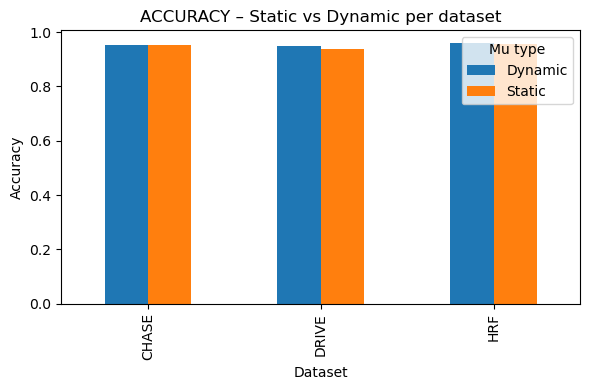

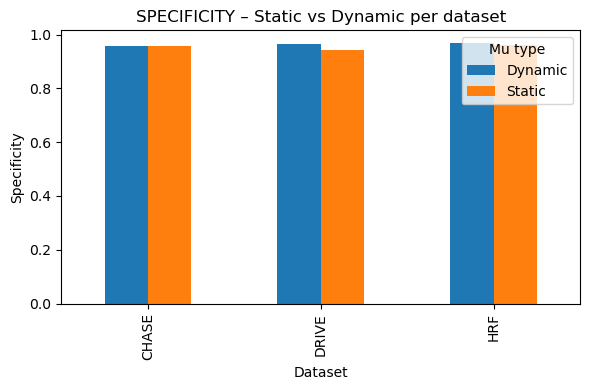

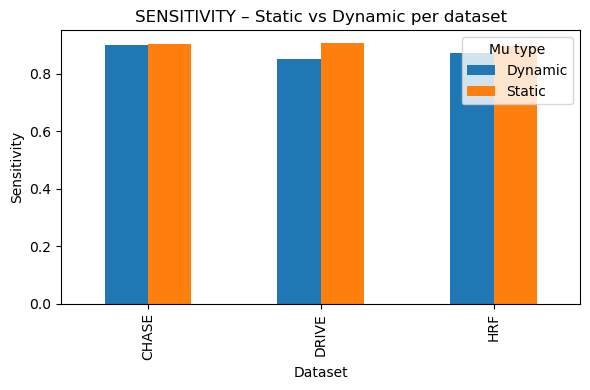

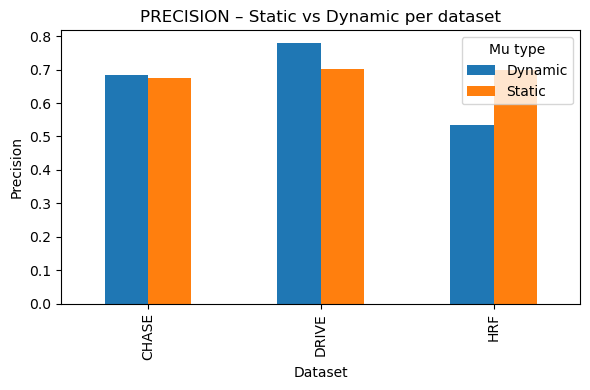

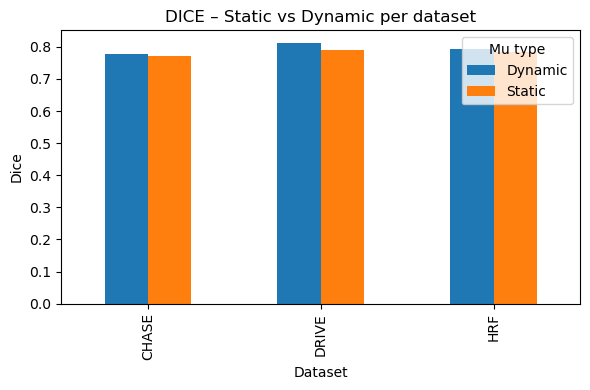

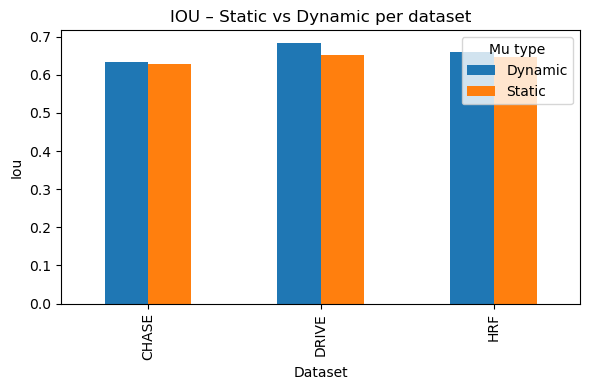

In [9]:
# Make plots look a bit nicer
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 10

for metric in metrics:
    summary = df_all.groupby(["dataset", "mu_type"])[metric].mean().reset_index()
    pivot = summary.pivot(index="dataset", columns="mu_type", values=metric)
    
    ax = pivot.plot(kind="bar")
    ax.set_title(f"{metric.upper()} – Static vs Dynamic per dataset")
    ax.set_xlabel("Dataset")
    ax.set_ylabel(metric.capitalize())
    ax.legend(title="Mu type")
    plt.tight_layout()
    plt.show()


C:\Users\rog\AppData\Local\Temp\ipykernel_31536\3630160301.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=labels, showfliers=False)


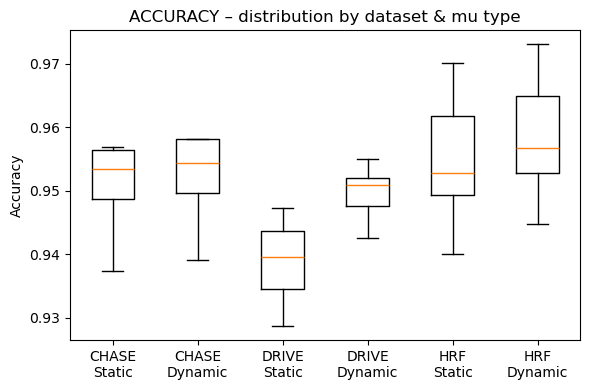

C:\Users\rog\AppData\Local\Temp\ipykernel_31536\3630160301.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=labels, showfliers=False)


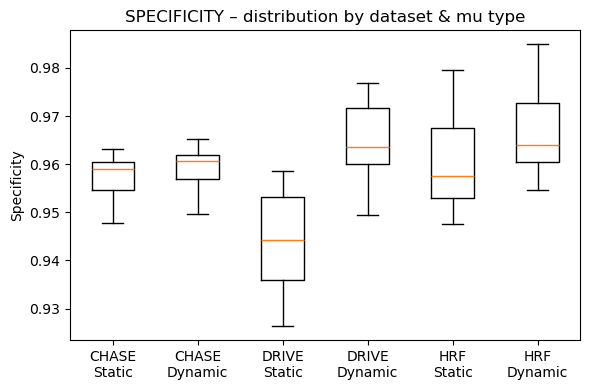

C:\Users\rog\AppData\Local\Temp\ipykernel_31536\3630160301.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=labels, showfliers=False)


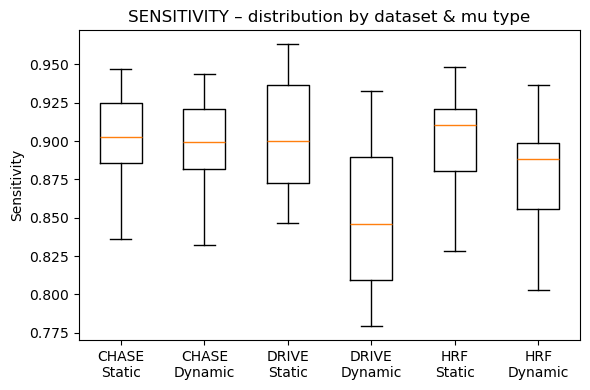

C:\Users\rog\AppData\Local\Temp\ipykernel_31536\3630160301.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=labels, showfliers=False)


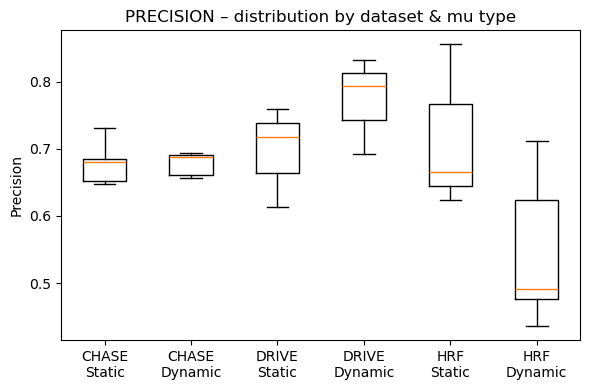

C:\Users\rog\AppData\Local\Temp\ipykernel_31536\3630160301.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=labels, showfliers=False)


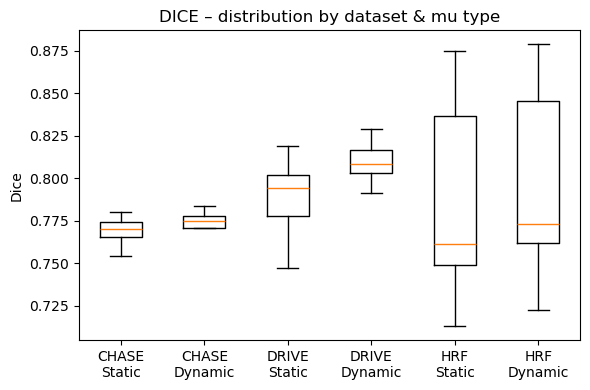

C:\Users\rog\AppData\Local\Temp\ipykernel_31536\3630160301.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=labels, showfliers=False)


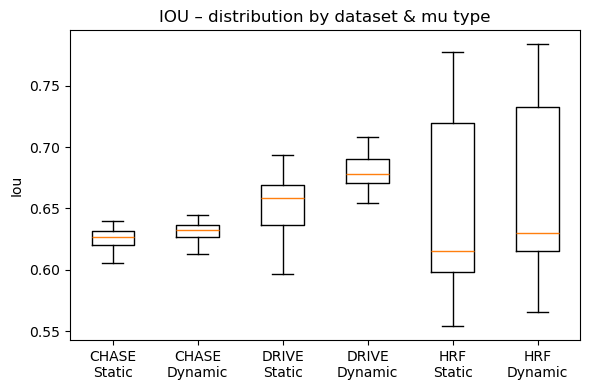

In [10]:
for metric in metrics:
    fig, ax = plt.subplots()
    
    # Build positions: 3 datasets × 2 mu types
    datasets = sorted(df_all["dataset"].unique())
    mu_types = ["Static", "Dynamic"]
    
    data_to_plot = []
    labels = []
    
    for ds in datasets:
        for mt in mu_types:
            vals = df_all[(df_all["dataset"] == ds) & (df_all["mu_type"] == mt)][metric].dropna()
            data_to_plot.append(vals)
            labels.append(f"{ds}\n{mt}")
    
    ax.boxplot(data_to_plot, labels=labels, showfliers=False)
    ax.set_title(f"{metric.upper()} – distribution by dataset & mu type")
    ax.set_ylabel(metric.capitalize())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
